Comparando as performances
========================================



## Introdução



Durante o primeiro mês do curso de Redes Neurais e Algoritmos Genéticos, fomos apresentados a diferentes algoritmos, como é o caso do algoritmo de busca aleatória, busca em grade e algoritmos genéticos. Dentre tais opções, torna-se interessante saber em que situações usar cada um dos algoritmos.

## Objetivo



O objetivo do presente experimento é de avaliar cada um dos algoritmos em função dos valores de fitness retornados e de tempo para a execução de código.

## Importações



In [35]:
import time
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from funcoes import funcao_objetivo_cb, individuo_cb
from funcoes import populacao_cb as cria_populacao_inicial
from funcoes import funcao_objetivo_pop_cb as funcao_objetivo_pop
from funcoes import selecao_roleta_max as funcao_selecao
from funcoes import cruzamento_ponto_simples as funcao_cruzamento
from funcoes import mutacao_cb as funcao_mutacao

## Códigos e discussão



Como forma de testar o problema das caixas binárias em relação ao método de busca aleatória, algoritmo genético e busca em grade, o método proposto foi:

- Definir funções com os métodos;
- Variar as constantes de gene e do tamanho da população, no caso de algoritmos genéticos;
- Armazenar os dados em um dataframe para poder analisar.



In [3]:
#Constantes

NUM_GERACOES = 5
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.05

In [13]:
def busca_aleatoria():
    inicio = time.time()
    candidatos = {}
    resultado_value = float('-inf')

    for n in range(TAMANHO_POP):
        candidato = individuo_cb(N_GENES)
        fobj = funcao_objetivo_cb(candidato)
        candidatos.update({str(candidato):fobj})

        if fobj > resultado_value:
            resultado_value = fobj
            resultado_key = candidato
    
    fim = time.time()
    #print(f'Após {round(fim-inicio,5)} segundos, score de {resultado_value}')
    return round(fim-inicio,5), resultado_value    

In [14]:
def busca_em_grade():
    inicio = time.time()
    candidatos = {}
    resultado_value = float('-inf')
    
    for individuo in itertools.product([0,1], repeat=N_GENES):
        fobj = funcao_objetivo_cb(individuo)
        candidatos.update({str(individuo):fobj})
        
        if fobj > resultado_value:
            resultado_value = fobj

    fim = time.time()
    #print(f'Após {round(fim-inicio,5)} segundos, score de {resultado_value}')
    return round(fim-inicio,5), resultado_value

In [15]:
def algoritmo_genetico():
    inicio = time.time()
    
    populacao = cria_populacao_inicial(TAMANHO_POP, N_GENES)

    #print(f'População inicial de pontuação igual a {sum(funcao_objetivo_pop(populacao))}: \n{populacao}\n')

    for _ in range(NUM_GERACOES):
        fitness = funcao_objetivo_pop(populacao)
        populacao = funcao_selecao(populacao,fitness)

        # Pais são pares, mães são ímpares
        pais = populacao[0::2]
        maes = populacao[1::2]

        contador = 0

        for pai, mae in zip(pais,maes):
            if random.random() < CHANCE_CRUZAMENTO:
                # Vai acontecer cruzamento
                filho1, filho2 = funcao_cruzamento(pai,mae)
                populacao[contador] = filho1
                populacao[contador+1] = filho2
            contador += 2

        for n in range(len(populacao)):
            if random.random() <= CHANCE_MUTACAO:
                #print(f'Indivíduo mutado: {populacao[n]}',end=' ')
                populacao[n] = funcao_mutacao(populacao[n])
                #print(populacao[n])
    
    fim = time.time()
    
    #print(f'Após {round(fim-inicio,5)} segundos, score de {max(fitness)}')
    return round(fim-inicio,5), max(fitness)

In [111]:
ba, ag = [], []

lista_tamanhos = [10]
lista_ngenes = range(10,1000,10)

for TAMANHO_POP, N_GENES in itertools.product(lista_tamanhos,lista_ngenes):
    tempo, score = busca_aleatoria()
    ba.append([TAMANHO_POP,N_GENES,tempo,score])
    
    tempo, score = algoritmo_genetico()
    ag.append([TAMANHO_POP,N_GENES,tempo,score])
    
ba_df = pd.DataFrame(ba, columns = ['Tamanho Pop','N Genes','Tempo','Score'])
ag_df = pd.DataFrame(ag, columns = ['Tamanho Pop','N Genes','Tempo','Score'])

### Importante

Como a busca em grade requer um tempo bastante grande de execução, valores baixos foram definidos para a execução. Além disso, a busca focou apenas na variação da quantidade de genes, a fim de comparar apenas esse quesito entre os métodos, ainda sendo possível observar como o tamanho da população para o algoritmo genético pode influenciar na execução do algoritmo.

In [112]:
bg = []

lista_tamanhos = [10]
lista_ngenes = range(10,20,5)

for TAMANHO_POP, N_GENES in itertools.product(lista_tamanhos,lista_ngenes):
    tempo, score = busca_em_grade()
    bg.append([TAMANHO_POP,N_GENES,tempo,score])

bg_df = pd.DataFrame(bg, columns = ['Tamanho Pop','N Genes','Tempo','Score'])

In [113]:
ba_df_genes = ba_df.iloc[:10,1:]
ag_df_genes = ag_df.iloc[:10,1:]
bg_df_genes = bg_df.iloc[:10,1:]

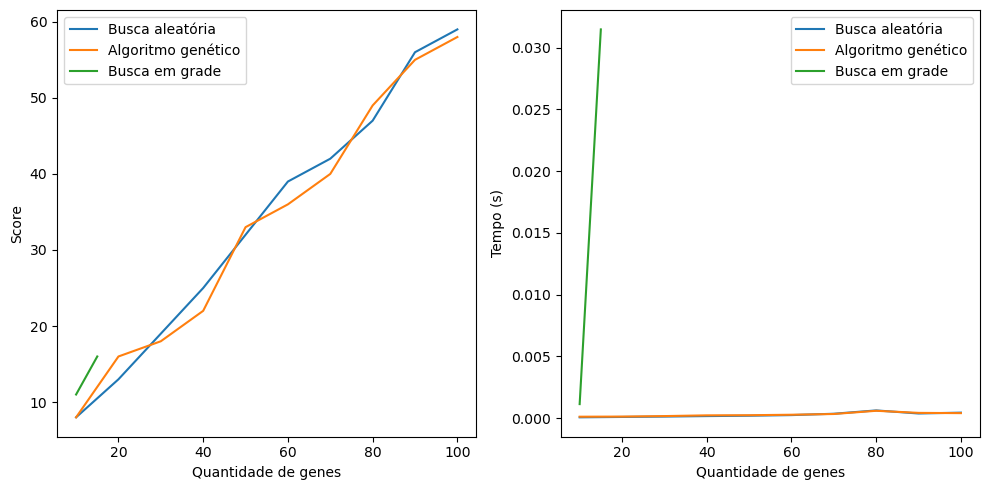

In [116]:
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1,2,1)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Score']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Score']),label='Algoritmo genético')
plt.plot(np.array(bg_df_genes['N Genes']),np.array(bg_df_genes['Score']),label='Busca em grade')

plt.xlabel('Quantidade de genes')
plt.ylabel('Score')
plt.legend()

fig.add_subplot(1,2,2)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Tempo']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Tempo']),label='Algoritmo genético')
plt.plot(np.array(bg_df_genes['N Genes']),np.array(bg_df_genes['Tempo']),label='Busca em grade')

plt.xlabel('Quantidade de genes')
plt.ylabel('Tempo (s)')
plt.legend()

plt.tight_layout()

plt.show()

Uma vez que o tempo de execução do algoritmo de busca aleatória é grande, dificulta a visualização do tempo dos outros algoritmos. Dessa forma, buscou-se analisar apenas a busca aleatória e o algoritmo genético.

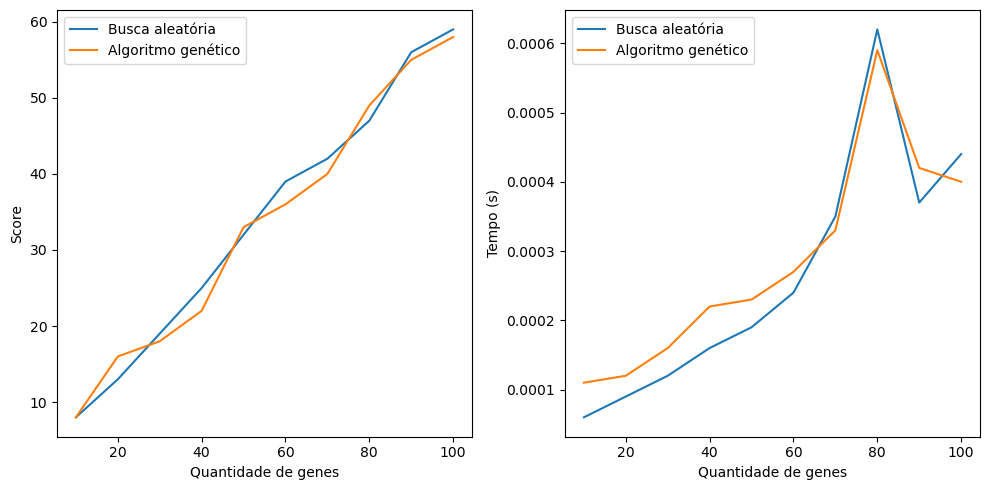

In [117]:
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1,2,1)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Score']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Score']),label='Algoritmo genético')

plt.xlabel('Quantidade de genes')
plt.ylabel('Score')
plt.legend()

fig.add_subplot(1,2,2)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Tempo']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Tempo']),label='Algoritmo genético')

plt.xlabel('Quantidade de genes')
plt.ylabel('Tempo (s)')
plt.legend()

plt.tight_layout()

plt.show()

## Conclusão



No presente experimento, buscou-se analisar o desempenho dos algoritmos testados no problema das caixas binárias, onde os fatores principais de análise foram o score e o tempo necessário para a execução.

Assim como esperado, para a busca em grade, que demanda a avaliação de todas as possibilidades do problema, o tempo foi enorme, tornando inviável a sua avaliação. Por outro lado, a busca aleatória e o algoritmo genético foram testados, obtendo valores bastante próximos, tanto para score quanto para tempo de execução.

Com a variação buscada neste notebook, o algoritmo genético demandou tempos maiores de execução em relação à busca aleatória, ao passo que os scores foram bastante similares. Isso pode indicar que, para problemas mais simples como é o caso das caixas binárias, a aplicação de algoritmos genéticos pode não ser a mais adequada.

## Playground



Todo código de teste que não faz parte do seu experimento deve vir aqui. Este código não será considerado na avaliação.

